# 4 Channel SegNet 2 Evaluation 

The basics of segmentation model evaluation will be experimented with in order to develop a repertoire of metrics. The main source of the work below is from the article at: https://www.jeremyjordan.me/evaluating-image-segmentation-models/

[Click here to skip down to the metrics](#start)

Note:
* the training set is used for experimenting with these metrics due to the lack of a ground truth label in the test set


In [1]:
#################### Imports #########################
from __future__ import print_function, division
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.models as models
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.nn.functional as F
from collections import OrderedDict
import time
import numpy as np
from torch.autograd import Variable
from pathlib import Path
from PIL import Image
# imports copied for loading in data
import os
import pandas as pd
#from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode
multiGPU = False
##### Tensor board requirements
import sys
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

In [2]:
from segnet2 import SegNet

In [3]:
######## unedited data class
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True):
        super().__init__()
        
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        
    def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir, gt_dir):
        
        files = {'red': r_file, 
                 'green':g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}

        return files
                                       
    def __len__(self):
        
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):

        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
    
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
    
        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
    

    def open_mask(self, idx, add_dims=False):
        
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)
        
        return x, y
    
    def open_as_pil(self, idx):
        
        arr = 256*self.open_as_array(idx)
        
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())

        return s

In [4]:
############ Load the test set ############
base_path = Path('38-Cloud_test')
data = CloudDataset(base_path/'test_red', 
                    base_path/'test_green', 
                    base_path/'test_blue', 
                    base_path/'test_nir',
                    base_path/'test_gt')

In [10]:
############ Load the test set ############
base_path = Path('38-Cloud_training')
data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt')

In [11]:
############ Create the test set data loader ############
bs = 12
test_dl = DataLoader(data, batch_size=bs, shuffle=True)

In [14]:
########### Load the model ###############
num_classes = 2   # assuming cloud and non cloud
num_channels = 4  # for the cloud data, for now
model = SegNet(num_channels,num_classes)

PATH = 'Segmentation Model Artifacts/SegNet2/SegNet2_state_dict_model_opt_lr_1.pt'

model.load_state_dict(torch.load(PATH))

if torch.cuda.is_available():
    model.cuda()

model.eval()
torch.no_grad()


<a id='start'></a>

# Initial Glance at Model Performance
* visual inspection of model performing on the training set
* re run the code below for a different set of examples
* overall, the model accuracy appears to be misleading due to the overwhelming presence of completely negative training examples

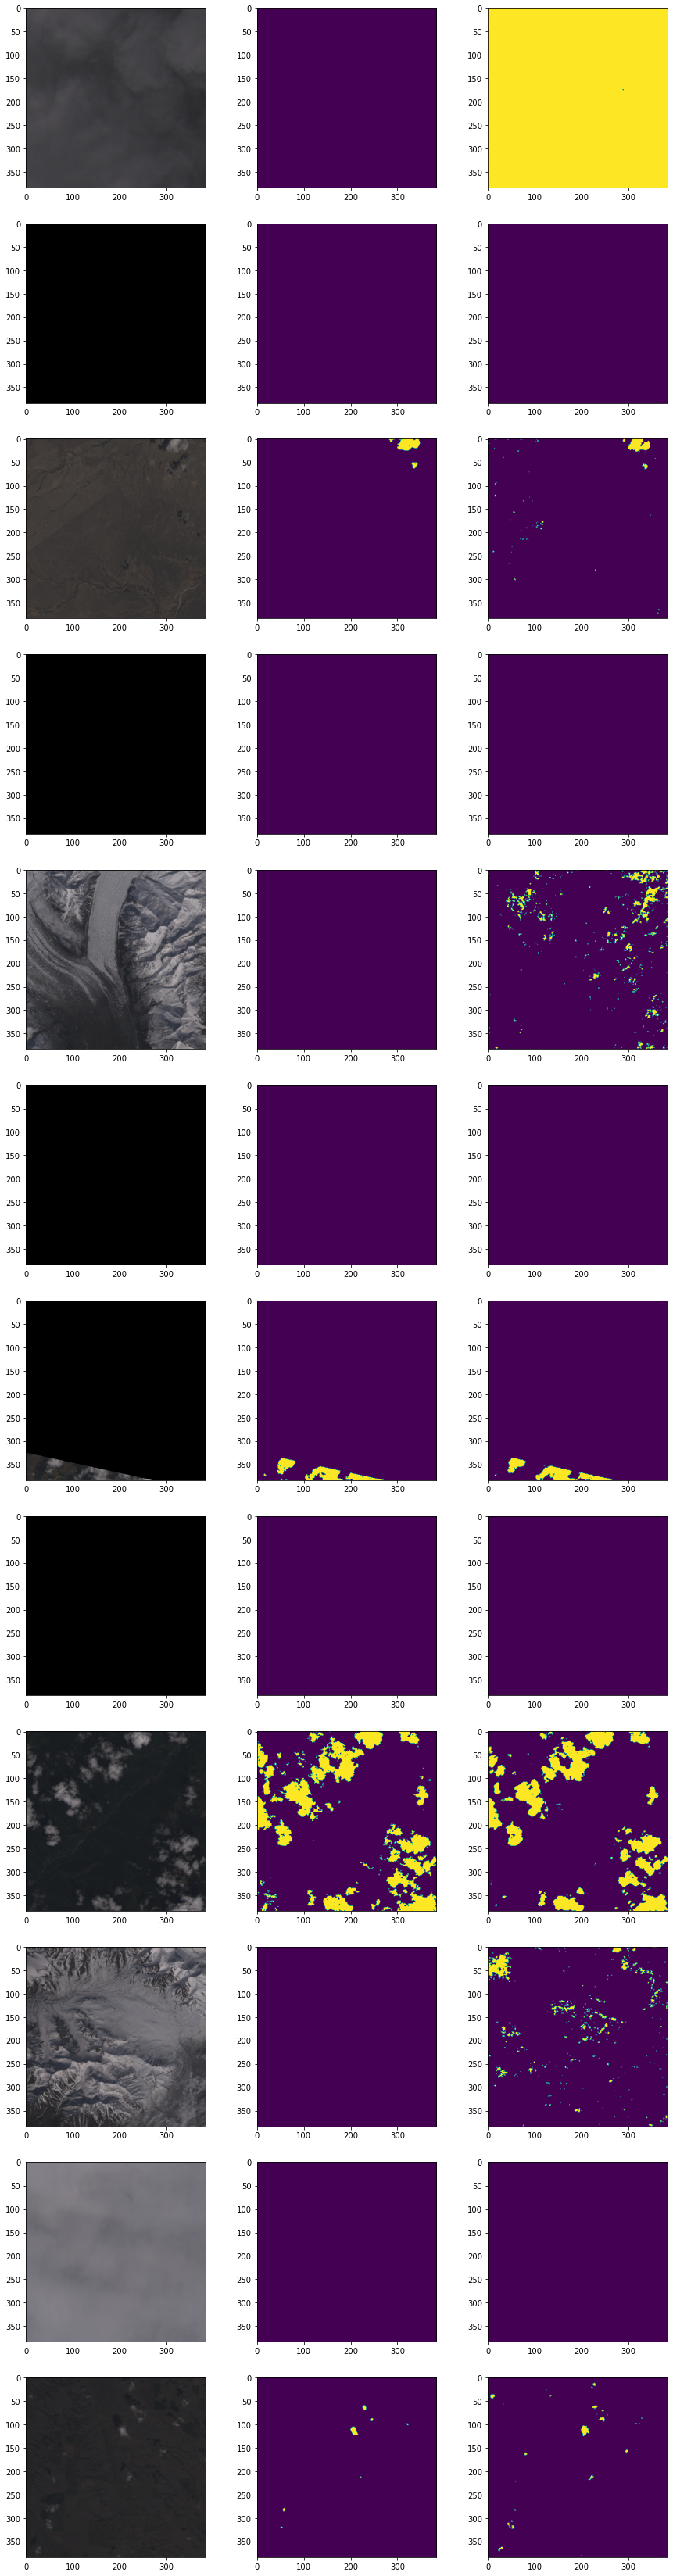

In [15]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

xb, yb = next(iter(test_dl))

with torch.no_grad():
    predb = model(xb.cuda())

fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

# Segmentation Model Metrics

## Intersection Over Union
* aka. the Jaccard index
* the metric is the ratio between the intersection of the prediction and target, divided by the union of the target and prediction


In [16]:
def itersection_over_union(pred, target, bs):
    pred = pred.cpu()
    pred = pred.detach().numpy()
    target = target.cpu()
    target = target.detach().numpy()
    
    iou_sum = 0.0
    for i in range(bs):
        intersection = np.logical_and(target[i], pred[i])
        union = np.logical_or(target[i], pred[i])
        iou_sum += np.sum(intersection) / np.sum(union)
        
    return iou_sum/bs
    
def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb).float().mean()

In [18]:
steps = 0
running_iou = 0 # intersection over union sum
for x, y in test_dl:
    steps += 1
    x = x.cuda()
    y = y.cuda()

    outputs = model(x)
    running_iou += itersection_over_union(outputs, y, test_dl.batch_size)


print('The IOU score is {}'.format(running_iou/steps))

RuntimeError: CUDA out of memory. Tried to allocate 216.00 MiB (GPU 0; 14.73 GiB total capacity; 13.77 GiB already allocated; 73.88 MiB free; 13.89 GiB reserved in total by PyTorch)